In [1]:
import numpy as np
import pandas as pd 
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import QFIE.FuzzyEngines as FE
import random
import matplotlib.pyplot as plt

L'elaborato si pone l'obiettivo di implementare un Quantum Fuzzy Controller per la gestione della regolazione di temperatura in un edificio pubblico, per il nostro scopo consideriamo un'aula studio universitaria con capienza massima di 24 persone dotata di telecamere, i dati di input per l'implementazione del nostro modello sono:  
-Il numero di persone   
-La temperatura esterna   
-La temperatura interna  
-L'umidità esterna   
-L'umidità interna   
-Ora del giorno  

Al fine di regolare il sistema di condizionamento 

# Ottenere i dati di input

Da cellulare o sfruttando una telecamera, possiamo implementare il seguente codice se i dispositivi sono connessi alla stessa rete locale per ottenere il numero di persone nell'aula tramite object detection

In [15]:
import cv2
url = "http://192.168.98.244:4747/video"

# Carico Yolo per il riconoscimento
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# apro il flusso video dalla telecamera o dal cellulare 
cap = cv2.VideoCapture(url)

while True:
    # cattura ogni frame 
    ret, frame = cap.read()
    if not ret:
        break
    height, width, channels = frame.shape

    # riconoscimento oggetti
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # box di riconoscimento
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and classes[class_id] == "person":
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    person_count = len(indexes)
    print(f"Number of people detected: {person_count}")

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = (0, 255, 0)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # vedere il video dal pc 
    cv2.imshow('Frame', frame)

    # premere q per terminare il processo
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# fine della connessione 
cap.release()
cv2.destroyAllWindows()


Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of people detected: 0
Number of peop

Ottenendo in real time il numero di persone presenti nella stanza che è uno dei dati di input
![Riconoscimento Persone](foto/Detection.JPG)  
Per quanto riguarda le condizioni ambientali, interne ed esterne possiamo usare per l'interno e per l'esterno degli appositi sensori

# Gestione Termostato

Funzione che prende in ingresso il vettore x contenente i dati di input per la gestione della temperatura  
I dati di input sono:

-Il numero di persone presenti nell'aula (Low, Medium, High)  
-La temperatura esterna (Very Low, Low, Medium, High, Very High)  
-La temperatura interna (Low, Medium, High)  
-Stato (Aperto, Chiuso)  

di cui definiamo e visualizziamo i fuzzy set come segue:

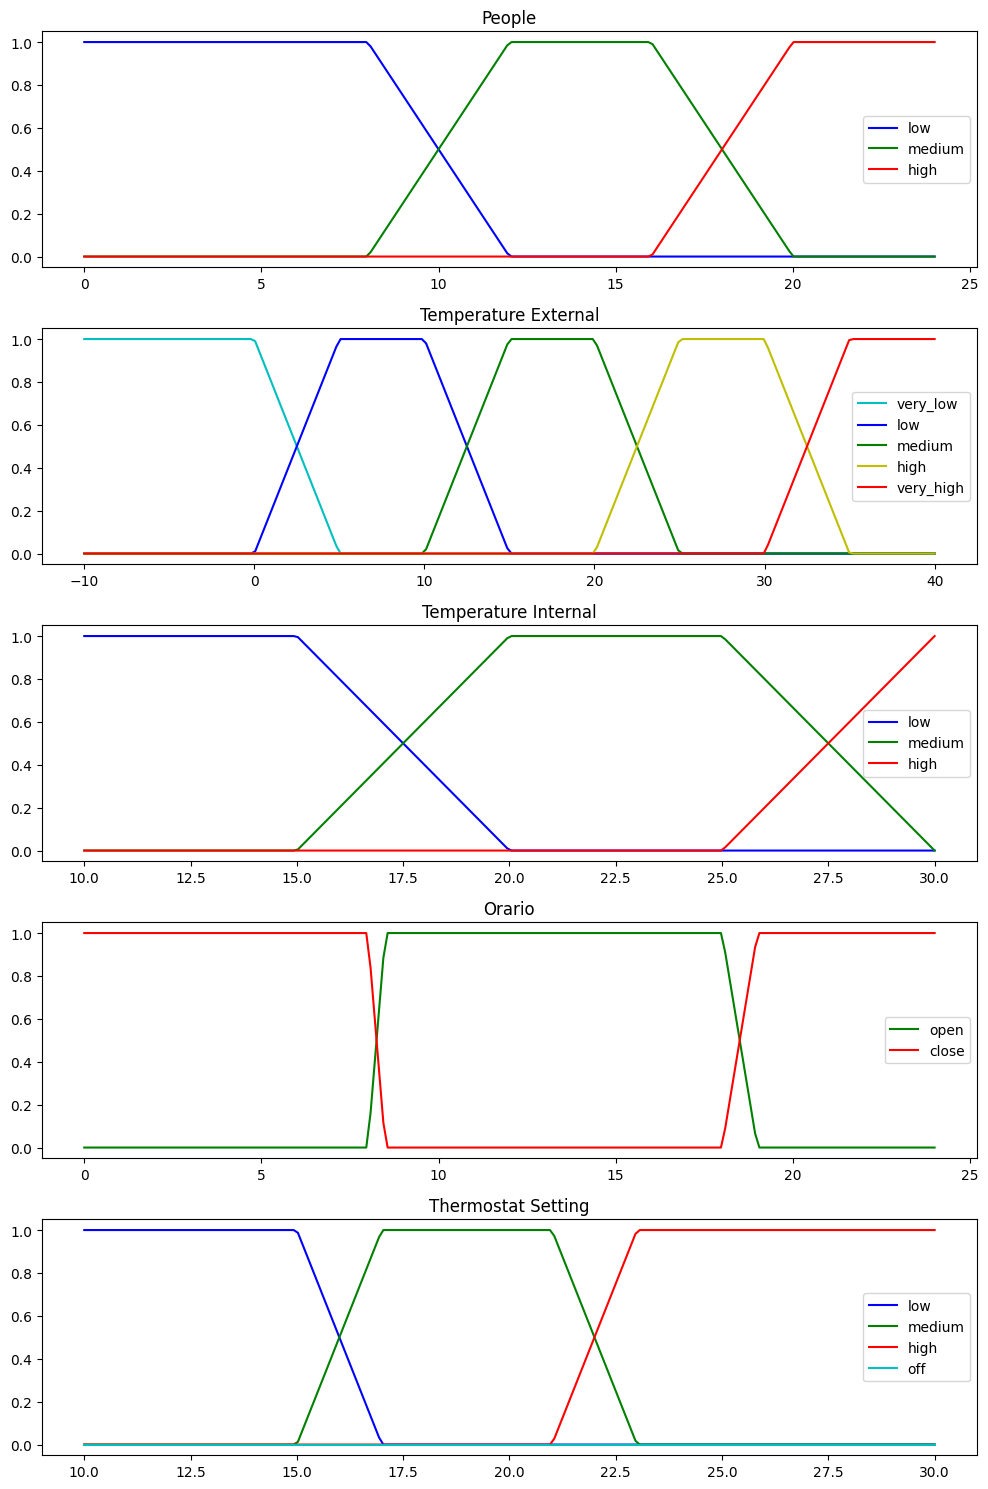

In [2]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

def plot_fuzzy_sets():
    people = np.linspace(0, 24, 200)
    temp_ext = np.linspace(-10, 40, 200)
    temp_int = np.linspace(10, 30, 200)
    orario = np.linspace(0, 24, 200)  
    thermostat_setting = np.linspace(10, 30, 200)

    # Definire i set fuzzy
    p_low = fuzz.trapmf(people, [0, 0, 8, 12])
    p_medium = fuzz.trapmf(people, [8, 12, 16, 20])
    p_high = fuzz.trapmf(people, [16, 20, 24, 24])

    te_very_low = fuzz.trapmf(temp_ext, [-10, -10, 0, 5])
    te_low = fuzz.trapmf(temp_ext, [0, 5, 10, 15])
    te_medium = fuzz.trapmf(temp_ext, [10, 15, 20, 25])
    te_high = fuzz.trapmf(temp_ext, [20, 25, 30, 35])
    te_very_high = fuzz.trapmf(temp_ext, [30, 35, 40, 40])

    ti_low = fuzz.trapmf(temp_int, [10, 10, 15, 20])
    ti_medium = fuzz.trapmf(temp_int, [15, 20, 25, 30])
    ti_high = fuzz.trapmf(temp_int, [25, 30, 30, 30])

    orario_open = fuzz.trapmf(orario, [8, 8.5, 18, 19])
    orario_close = fuzz.trapmf(orario, [0, 0, 8, 8.5]) + fuzz.trapmf(orario, [18, 19, 24, 24])

    thermostat_off = fuzz.trapmf(thermostat_setting, [0, 0, 0, 0])
    thermostat_low = fuzz.trapmf(thermostat_setting, [10, 10, 15, 17])
    thermostat_medium = fuzz.trapmf(thermostat_setting, [15, 17, 21, 23])
    thermostat_high = fuzz.trapmf(thermostat_setting, [21, 23, 30, 30])

    # Plotting
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

    axs[0].plot(people, p_low, 'b', label='low')
    axs[0].plot(people, p_medium, 'g', label='medium')
    axs[0].plot(people, p_high, 'r', label='high')
    axs[0].set_title('People')
    axs[0].legend()

    axs[1].plot(temp_ext, te_very_low, 'c', label='very_low')
    axs[1].plot(temp_ext, te_low, 'b', label='low')
    axs[1].plot(temp_ext, te_medium, 'g', label='medium')
    axs[1].plot(temp_ext, te_high, 'y', label='high')
    axs[1].plot(temp_ext, te_very_high, 'r', label='very_high')
    axs[1].set_title('Temperature External')
    axs[1].legend()

    axs[2].plot(temp_int, ti_low, 'b', label='low')
    axs[2].plot(temp_int, ti_medium, 'g', label='medium')
    axs[2].plot(temp_int, ti_high, 'r', label='high')
    axs[2].set_title('Temperature Internal')
    axs[2].legend()

    axs[3].plot(orario, orario_open, 'g', label='open')
    axs[3].plot(orario, orario_close, 'r', label='close')
    axs[3].set_title('Orario')
    axs[3].legend()

    axs[4].plot(thermostat_setting, thermostat_low, 'b', label='low')
    axs[4].plot(thermostat_setting, thermostat_medium, 'g', label='medium')
    axs[4].plot(thermostat_setting, thermostat_high, 'r', label='high')
    axs[4].plot(thermostat_setting, thermostat_off, 'c', label='off')
    axs[4].set_title('Thermostat Setting')
    axs[4].legend()

    plt.tight_layout()
    plt.show()

plot_fuzzy_sets()


In [3]:
def temperature_control(x):
    # range delle variabili di input
    people = np.linspace(0, 24, 200)
    temp_ext = np.linspace(-10, 40, 200)
    temp_int = np.linspace(10, 30, 200)
    orario = np.linspace(0, 24, 200)  # range da 0 a 24 ore
    thermostat_setting = np.linspace(0, 30, 200)

    # Definire i set fuzzy per le variabili di input e output
    p_low = fuzz.trapmf(people, [0, 0, 8, 12])
    p_medium = fuzz.trapmf(people, [8, 12, 16, 20])
    p_high = fuzz.trapmf(people, [16, 20, 24, 24])

    te_very_low = fuzz.trapmf(temp_ext, [-10, -10, 0, 5])
    te_low = fuzz.trapmf(temp_ext, [0, 5, 10, 15])
    te_medium = fuzz.trapmf(temp_ext, [10, 15, 20, 25])
    te_high = fuzz.trapmf(temp_ext, [20, 25, 30, 35])
    te_very_high = fuzz.trapmf(temp_ext, [30, 35, 40, 40])

    ti_low = fuzz.trapmf(temp_int, [10, 10, 15, 20])
    ti_medium = fuzz.trapmf(temp_int, [15, 20, 25, 30])
    ti_high = fuzz.trapmf(temp_int, [25, 30, 30, 30])

    orario_open = fuzz.trapmf(orario, [8, 8.5, 18, 19])
    orario_close = fuzz.trapmf(orario, [0, 0, 8, 8.5]) + fuzz.trapmf(orario, [18, 19, 24, 24])

    thermostat_off = fuzz.trapmf(thermostat_setting, [0, 0, 0, 0])
    thermostat_low = fuzz.trapmf(thermostat_setting, [10, 10, 15, 17])
    thermostat_medium = fuzz.trapmf(thermostat_setting, [15, 17, 21, 23])
    thermostat_high = fuzz.trapmf(thermostat_setting, [21, 23, 30, 30])

    # Regole
    rules = [
        'if people is low and temp_ext is very_low and temp_int is low and orario is open then thermostat_setting is high',
        'if people is low and temp_ext is very_low and temp_int is low and orario is close then thermostat_setting is off',
        'if people is low and temp_ext is very_low and temp_int is medium and orario is open then thermostat_setting is high',
        'if people is low and temp_ext is very_low and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is low and temp_ext is very_low and temp_int is high and orario is open then thermostat_setting is medium',
        'if people is low and temp_ext is very_low and temp_int is high and orario is close then thermostat_setting is off',
        
        'if people is low and temp_ext is low and temp_int is low and orario is open then thermostat_setting is high',
        'if people is low and temp_ext is low and temp_int is low and orario is close then thermostat_setting is off',
        'if people is low and temp_ext is low and temp_int is medium and orario is open then thermostat_setting is high',
        'if people is low and temp_ext is low and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is low and temp_ext is low and temp_int is high and orario is open then thermostat_setting is medium',
        'if people is low and temp_ext is low and temp_int is high and orario is close then thermostat_setting is off',

        'if people is low and temp_ext is medium and temp_int is low and orario is open then thermostat_setting is medium',
        'if people is low and temp_ext is medium and temp_int is low and orario is close then thermostat_setting is off',
        'if people is low and temp_ext is medium and temp_int is medium and orario is open then thermostat_setting is medium',
        'if people is low and temp_ext is medium and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is low and temp_ext is medium and temp_int is high and orario is open then thermostat_setting is low',
        'if people is low and temp_ext is medium and temp_int is high and orario is close then thermostat_setting is off',

        'if people is low and temp_ext is high and temp_int is low and orario is open then thermostat_setting is medium',
        'if people is low and temp_ext is high and temp_int is low and orario is close then thermostat_setting is off',
        'if people is low and temp_ext is high and temp_int is medium and orario is open then thermostat_setting is medium',
        'if people is low and temp_ext is high and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is low and temp_ext is high and temp_int is high and orario is open then thermostat_setting is low',
        'if people is low and temp_ext is high and temp_int is high and orario is close then thermostat_setting is off',

        'if people is low and temp_ext is very_high and temp_int is low and orario is open then thermostat_setting is medium',
        'if people is low and temp_ext is very_high and temp_int is low and orario is close then thermostat_setting is off',
        'if people is low and temp_ext is very_high and temp_int is medium and orario is open then thermostat_setting is low',
        'if people is low and temp_ext is very_high and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is low and temp_ext is very_high and temp_int is high and orario is open then thermostat_setting is low',
        'if people is low and temp_ext is very_high and temp_int is high and orario is close then thermostat_setting is off',

        'if people is medium and temp_ext is very_low and temp_int is low and orario is open then thermostat_setting is high',
        'if people is medium and temp_ext is very_low and temp_int is low and orario is close then thermostat_setting is off',
        'if people is medium and temp_ext is very_low and temp_int is medium and orario is open then thermostat_setting is high',
        'if people is medium and temp_ext is very_low and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is medium and temp_ext is very_low and temp_int is high and orario is open then thermostat_setting is medium',
        'if people is medium and temp_ext is very_low and temp_int is high and orario is close then thermostat_setting is off',

        'if people is medium and temp_ext is low and temp_int is low and orario is open then thermostat_setting is high',
        'if people is medium and temp_ext is low and temp_int is low and orario is close then thermostat_setting is off',
        'if people is medium and temp_ext is low and temp_int is medium and orario is open then thermostat_setting is high',
        'if people is medium and temp_ext is low and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is medium and temp_ext is low and temp_int is high and orario is open then thermostat_setting is medium',
        'if people is medium and temp_ext is low and temp_int is high and orario is close then thermostat_setting is off',

        'if people is medium and temp_ext is medium and temp_int is low and orario is open then thermostat_setting is medium',
        'if people is medium and temp_ext is medium and temp_int is low and orario is close then thermostat_setting is off',
        'if people is medium and temp_ext is medium and temp_int is medium and orario is open then thermostat_setting is medium',
        'if people is medium and temp_ext is medium and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is medium and temp_ext is medium and temp_int is high and orario is open then thermostat_setting is low',
        'if people is medium and temp_ext is medium and temp_int is high and orario is close then thermostat_setting is off',

        'if people is medium and temp_ext is high and temp_int is low and orario is open then thermostat_setting is medium',
        'if people is medium and temp_ext is high and temp_int is low and orario is close then thermostat_setting is off',
        'if people is medium and temp_ext is high and temp_int is medium and orario is open then thermostat_setting is medium',
        'if people is medium and temp_ext is high and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is medium and temp_ext is high and temp_int is high and orario is open then thermostat_setting is low',
        'if people is medium and temp_ext is high and temp_int is high and orario is close then thermostat_setting is off',

        'if people is medium and temp_ext is very_high and temp_int is low and orario is open then thermostat_setting is medium',
        'if people is medium and temp_ext is very_high and temp_int is low and orario is close then thermostat_setting is off',
        'if people is medium and temp_ext is very_high and temp_int is medium and orario is open then thermostat_setting is low',
        'if people is medium and temp_ext is very_high and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is medium and temp_ext is very_high and temp_int is high and orario is open then thermostat_setting is low',
        'if people is medium and temp_ext is very_high and temp_int is high and orario is close then thermostat_setting is off',

        'if people is high and temp_ext is very_low and temp_int is low and orario is open then thermostat_setting is high',
        'if people is high and temp_ext is very_low and temp_int is low and orario is close then thermostat_setting is off',
        'if people is high and temp_ext is very_low and temp_int is medium and orario is open then thermostat_setting is high',
        'if people is high and temp_ext is very_low and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is high and temp_ext is very_low and temp_int is high and orario is open then thermostat_setting is medium',
        'if people is high and temp_ext is very_low and temp_int is high and orario is close then thermostat_setting is off',

        'if people is high and temp_ext is low and temp_int is low and orario is open then thermostat_setting is high',
        'if people is high and temp_ext is low and temp_int is low and orario is close then thermostat_setting is off',
        'if people is high and temp_ext is low and temp_int is medium and orario is open then thermostat_setting is high',
        'if people is high and temp_ext is low and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is high and temp_ext is low and temp_int is high and orario is open then thermostat_setting is medium',
        'if people is high and temp_ext is low and temp_int is high and orario is close then thermostat_setting is off',

        'if people is high and temp_ext is medium and temp_int is low and orario is open then thermostat_setting is medium',
        'if people is high and temp_ext is medium and temp_int is low and orario is close then thermostat_setting is off',
        'if people is high and temp_ext is medium and temp_int is medium and orario is open then thermostat_setting is medium',
        'if people is high and temp_ext is medium and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is high and temp_ext is medium and temp_int is high and orario is open then thermostat_setting is low',
        'if people is high and temp_ext is medium and temp_int is high and orario is close then thermostat_setting is off',

        'if people is high and temp_ext is high and temp_int is low and orario is open then thermostat_setting is medium',
        'if people is high and temp_ext is high and temp_int is low and orario is close then thermostat_setting is off',
        'if people is high and temp_ext is high and temp_int is medium and orario is open then thermostat_setting is medium',
        'if people is high and temp_ext is high and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is high and temp_ext is high and temp_int is high and orario is open then thermostat_setting is low',
        'if people is high and temp_ext is high and temp_int is high and orario is close then thermostat_setting is off',

        'if people is high and temp_ext is very_high and temp_int is low and orario is open then thermostat_setting is medium',
        'if people is high and temp_ext is very_high and temp_int is low and orario is close then thermostat_setting is off',
        'if people is high and temp_ext is very_high and temp_int is medium and orario is open then thermostat_setting is low',
        'if people is high and temp_ext is very_high and temp_int is medium and orario is close then thermostat_setting is off',
        'if people is high and temp_ext is very_high and temp_int is high and orario is open then thermostat_setting is low',
        'if people is high and temp_ext is very_high and temp_int is high and orario is close then thermostat_setting is off',
    ]

    qfie = FE.QuantumFuzzyEngine(verbose=True)

    qfie.input_variable(name='people', range=people)
    qfie.input_variable(name='temp_ext', range=temp_ext)
    qfie.input_variable(name='temp_int', range=temp_int)
    qfie.input_variable(name='orario', range=orario)
    qfie.output_variable(name='thermostat_setting', range=thermostat_setting)

    qfie.add_input_fuzzysets(var_name='people', set_names=['low', 'medium', 'high'], sets=[p_low, p_medium, p_high])
    qfie.add_input_fuzzysets(var_name='temp_ext', set_names=['very_low', 'low', 'medium', 'high', 'very_high'], sets=[te_very_low, te_low, te_medium, te_high, te_very_high])
    qfie.add_input_fuzzysets(var_name='temp_int', set_names=['low', 'medium', 'high'], sets=[ti_low, ti_medium, ti_high])
    qfie.add_input_fuzzysets(var_name='orario', set_names=['open', 'close'], sets=[orario_open, orario_close])
    qfie.add_output_fuzzysets(var_name='thermostat_setting', set_names=['off', 'low', 'medium', 'high'], sets=[thermostat_off, thermostat_low, thermostat_medium, thermostat_high])
    
    qfie.set_rules(rules)

    qfie.build_inference_qc({'people': x[0], 'temp_ext': x[1], 'temp_int': x[2], 'orario': x[3]}, distributed=False, draw_qc=False)
    
    s = qfie.execute(n_shots=1000)[0]

    return s


In [26]:
def test_temperature_control():
    test_cases = [
        {'people': 5, 'temp_ext': -5, 'temp_int': 15, 'orario': 9},   # Low people, very low temp_ext, low temp_int, open
        {'people': 15, 'temp_ext': 20, 'temp_int': 22, 'orario': 14}, # Medium people, medium temp_ext, medium temp_int, open
        {'people': 22, 'temp_ext': 35, 'temp_int': 28, 'orario': 20}, # High people, very high temp_ext, high temp_int, close
        {'people': 10, 'temp_ext': 5, 'temp_int': 18, 'orario': 12},  # Medium people, low temp_ext, medium temp_int, open
        {'people': 3, 'temp_ext': 25, 'temp_int': 26, 'orario': 23},   # Low people, high temp_ext, high temp_int, close
        {'people': 22, 'temp_ext': 30, 'temp_int': 28, 'orario': 15} # High people, very high temp_ext, high temp_int, open
    ]
    
    for i, case in enumerate(test_cases):
        x = [case['people'], case['temp_ext'], case['temp_int'], case['orario']]
        setting = temperature_control(x)
        print(f"Test Case {i+1}: People={case['people']}, Temp Ext={case['temp_ext']}, Temp Int={case['temp_int']}, Orario={case['orario']}")
        print(f"Thermostat Setting: {setting}\n")

test_temperature_control()

{'people': 5, 'temp_ext': -5, 'temp_int': 15, 'orario': 9}
Input values  {'people': [np.float64(1.0), np.float64(0.0), np.float64(0.0)], 'temp_ext': [np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], 'temp_int': [np.float64(0.9962311557788945), np.float64(0.0037688442211054607), np.float64(0.0)], 'orario': [np.float64(1.0), np.float64(0.0)]}
Running qc full_circuit on qasm_simulator
Output Counts {'0001': 0, '0010': 0, '0100': 0, '1000': 1.0}
Test Case 1: People=5, Temp Ext=-5, Temp Int=15, Orario=9
Thermostat Setting: 25.978947769148768

{'people': 15, 'temp_ext': 20, 'temp_int': 22, 'orario': 14}
Input values  {'people': [np.float64(0.0), np.float64(1.0), np.float64(0.0)], 'temp_ext': [np.float64(0.0), np.float64(0.0), np.float64(0.9879396984924622), np.float64(0.01206030150753773), np.float64(0.0)], 'temp_int': [np.float64(0.0), np.float64(1.0), np.float64(0.0)], 'orario': [np.float64(1.0), np.float64(0.0)]}
Running qc full_circuit on qasm_simulat

## Inferenza

### Input e Fuzzificazione

Nel caso di:
- **Input**: {'people': 22, 'temp_ext': 30, 'temp_int': 28, 'orario': 15}

Questi valori rappresentano le variabili di ingresso del sistema:
- `people`: 22 persone
- `temp_ext`: 30°C (temperatura esterna)
- `temp_int`: 28°C (temperatura interna)
- `orario`: 15 (presumibilmente l'ora in formato 24 ore)

### Fuzzificazione

Gli input crisp vengono trasformati in valori fuzzy basati sui set fuzzy definiti:

- `people`: 
  - `low`: 0.0
  - `medium`: 0.0
  - `high`: 1.0

- `temp_ext`: 
  - `very_low`: 0.0
  - `low`: 0.0
  - `medium`: 0.0
  - `high`: 0.99196
  - `very_high`: 0.00804

- `temp_int`: 
  - `low`: 0.0
  - `medium`: 0.4
  - `high`: 0.6

- `orario`: 
  - `open`: 1.0
  - `close`: 0.0

Questi valori rappresentano il grado di appartenenza a ciascun set fuzzy. Ad esempio, `people` è completamente nella categoria `high` e `temp_ext` è principalmente nella categoria `high`.

### Configurazione del QFIE

Il motore di inferenza fuzzy quantistico (QFIE) è configurato con le variabili di input e output e i loro rispettivi set fuzzy. Le regole fuzzy vengono definite per il sistema.

### Costruzione ed Esecuzione del Circuito Quantistico

Il `QuantumFuzzyEngine` costruisce un circuito quantistico basato sugli input fuzzificati, i set fuzzy e le regole definite. Il circuito viene eseguito N volte su un simulatore QASM per ottenere le distribuzioni di probabilità degli stati di output dove eseguendolo N volte abbiamo una robustezza nelle probabilità ricavate.

### Risultati del Circuito Quantistico

Le distribuzioni di probabilità degli stati di output sono:
- `0001`: 0.0
- `0010`: 60.5%
- `0100`: 39.5%
- `1000`: 0.0

Questi stati corrispondono a diverse regole fuzzy attivate nel motore di inferenza fuzzy quantistico.

### Inferenza Fuzzy e Defuzzificazione

I risultati dell'inferenza fuzzy vengono ottenuti dalle distribuzioni di probabilità e poi defuzzificati per produrre l'output finale. In questo caso:

- **Test Case 6**: People=22, Temp Ext=30, Temp Int=28, Orario=15
- **Thermostat Setting**: 15.651511925081017

Il valore finale dell'impostazione del termostato è ottenuto dai gradi di appartenenza ai set fuzzy di output utilizzando il metodo del centro di gravità:  


$$
\hat{y} = \frac{\int_{y_l}^{y_u} y \cdot \mu_Y(y) \, dy}{\int_{y_l}^{y_u} \mu_Y(y) \, dy}
$$

dove:

- yl  è il limite inferiore dell'universo del discorso della variabile di output \( Y \).
- yu  è il limite superiore dell'universo del discorso della variabile di output \( Y \).
- mu  è la funzione di appartenenza fuzzy della variabile di output \( Y \).


In [4]:
def simulate_day():
    hours = range(7, 19)
    people_range = (0, 24)
    temp_ext_range = (-10, 40)
    initial_temp_ext = random.uniform(*temp_ext_range)
    temp_int_range = (10, 30)
    initial_temp_int = random.uniform(*temp_int_range)
    
    data = []
    temp_ext = initial_temp_ext
    temp_int = initial_temp_int
    
    first_iteration = True
    
    for hour in hours:
        if first_iteration:
            people = 1
            first_iteration = False
        else:
            people = random.randint(*people_range)
        
        # Oscillazione contenuta della temperatura esterna
        temp_ext = temp_ext + random.uniform(-0.5, 0.5)
        temp_ext = max(min(temp_ext, temp_ext_range[1]), temp_ext_range[0])
        
        orario = hour
        
        x = [people, temp_ext, temp_int, orario]
        setting = temperature_control(x)
        
        # Modificare la temperatura interna in base all'impostazione del termostato
        if setting < 10:
            temp_int = temp_ext  # Se il termostato è spento, la temperatura interna diventa uguale a quella esterna
        else:
            target_temp = round(setting)  # Portare la temperatura interna al valore arrotondato di setting
            if temp_int < target_temp:
                temp_int += min(0.5, target_temp - temp_int)  # Aumenta gradualmente la temperatura interna
            elif temp_int > target_temp:
                temp_int -= min(0.5, temp_int - target_temp)  # Diminuisci gradualmente la temperatura interna
        
        temp_int = max(min(temp_int, temp_int_range[1]), temp_int_range[0])

        data.append({
            'Hour': hour,
            'People': people,
            'External Temperature': temp_ext,
            'Internal Temperature': temp_int,
            'Time': orario,
            'Thermostat Setting': setting
        })
    
    return pd.DataFrame(data)

simulation = simulate_day()


{'people': 1, 'temp_ext': 21.690839430630156, 'temp_int': 17.517996327206394, 'orario': 7}
Input values  {'people': [np.float64(1.0), np.float64(0.0), np.float64(0.0)], 'temp_ext': [np.float64(0.0), np.float64(0.0), np.float64(0.6618321138739688), np.float64(0.33816788612603116), np.float64(0.0)], 'temp_int': [np.float64(0.4964007345587213), np.float64(0.5035992654412788), np.float64(0.0)], 'orario': [np.float64(0.0), np.float64(1.0)]}
Running qc full_circuit on qasm_simulator
Output Counts {'0001': 1.0, '0010': 0, '0100': 0, '1000': 0}
{'people': 16, 'temp_ext': 21.6852090212765, 'temp_int': 21.690839430630156, 'orario': 8}
Input values  {'people': [np.float64(0.0), np.float64(0.9932998324958124), np.float64(0.006700167504187535)], 'temp_ext': [np.float64(0.0), np.float64(0.0), np.float64(0.6629581957447002), np.float64(0.33704180425529984), np.float64(0.0)], 'temp_int': [np.float64(0.0), np.float64(1.0), np.float64(0.0)], 'orario': [np.float64(0.05360134003350107), np.float64(0.94639

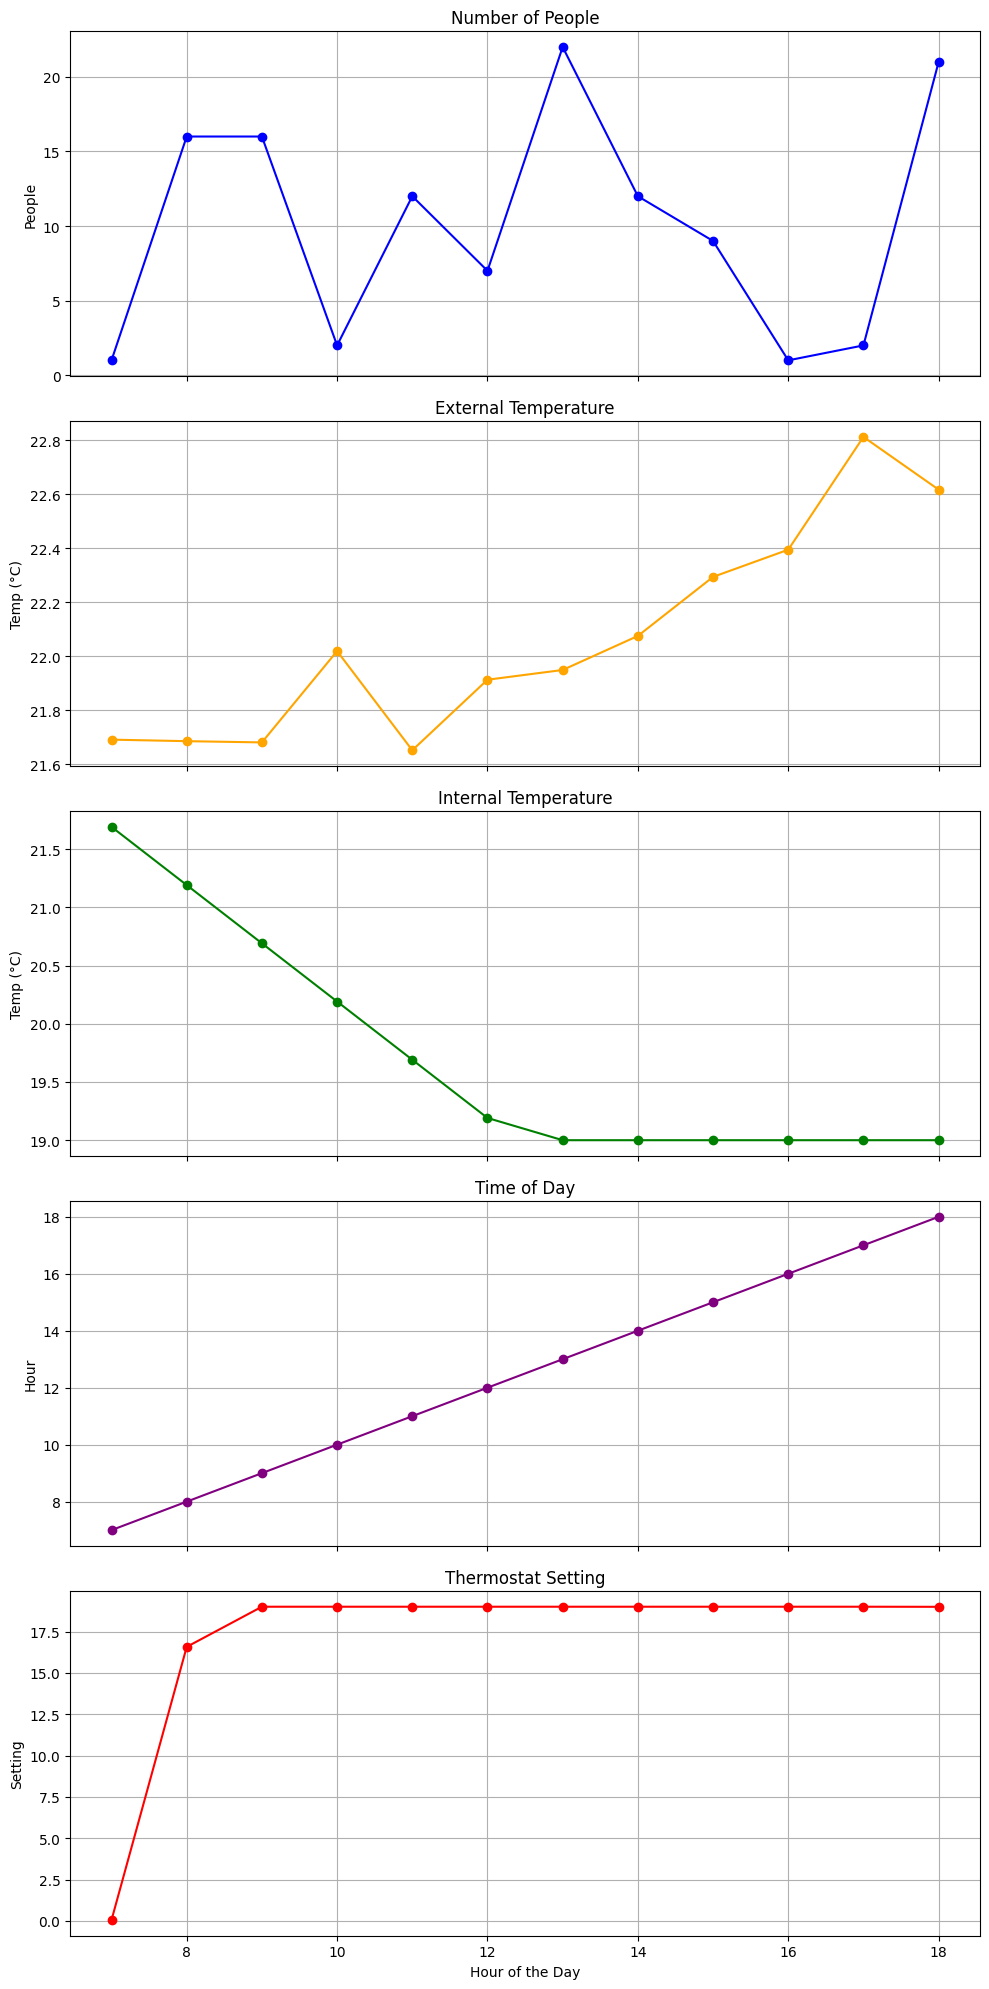

In [5]:

def plot_simulation_results(df):
    fig, axs = plt.subplots(5, 1, figsize=(10, 20), sharex=True)

    axs[0].plot(df['Hour'], df['People'], marker='o', linestyle='-', color='b')
    axs[0].set_title('Number of People')
    axs[0].set_ylabel('People')

    axs[1].plot(df['Hour'], df['External Temperature'], marker='o', linestyle='-', color='orange')
    axs[1].set_title('External Temperature')
    axs[1].set_ylabel('Temp (°C)')

    axs[2].plot(df['Hour'], df['Internal Temperature'], marker='o', linestyle='-', color='green')
    axs[2].set_title('Internal Temperature')
    axs[2].set_ylabel('Temp (°C)')

    axs[3].plot(df['Hour'], df['Time'], marker='o', linestyle='-', color='purple')
    axs[3].set_title('Time of Day')
    axs[3].set_ylabel('Hour')

    axs[4].plot(df['Hour'], df['Thermostat Setting'], marker='o', linestyle='-', color='red')
    axs[4].set_title('Thermostat Setting')
    axs[4].set_ylabel('Setting')

    for ax in axs:
        ax.grid(True)
    
    axs[4].set_xlabel('Hour of the Day')
    plt.tight_layout()
    plt.show()

plot_simulation_results(simulation)

In [28]:

def create_classroom_image(hour, people, temp_ext, temp_int, thermostat_setting):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Aula rettangolare
    classroom = patches.Rectangle((0.1, 0.1), 0.8, 0.6, linewidth=1, edgecolor='black', facecolor='lightgrey')
    ax.add_patch(classroom)
    
    # Testo per l'ora
    ax.text(0.5, 0.8, f'Ora: {hour}:00', fontsize=14, ha='center')
    
    # Testo per il numero di persone
    ax.text(0.5, 0.75, f'Persone: {people}', fontsize=14, ha='center')
    
    # Testo per la temperatura esterna
    ax.text(0.5, 0.7, f'Temperatura Esterna: {temp_ext:.1f}°C', fontsize=14, ha='center')
    
    # Testo per la temperatura interna
    ax.text(0.5, 0.65, f'Temperatura Interna: {temp_int:.1f}°C', fontsize=14, ha='center')
    
    # Testo per l'impostazione del termostato
    setting_text = "Spento" if thermostat_setting < 10 else f'Impostazione Termostato: {thermostat_setting:.1f}°C'
    ax.text(0.5, 0.6, setting_text, fontsize=14, ha='center')
    
    # Persone nell'aula
    for i in range(int(people)):  # Convertire people in un intero
        x = 0.15 + (i % 8) * 0.1
        y = 0.5 - (i // 8) * 0.1
        person = patches.Circle((x, y), 0.02, linewidth=1, edgecolor='black', facecolor='blue')
        ax.add_patch(person)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    plt.close(fig)
    
    # Salva la figura come immagine
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')  # Utilizzare buffer_rgba al posto di tostring_rgb
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    
    return image

# Funzione per creare una GIF dalle immagini
def create_gif(images, filename='classroom_simulation.gif'):
    imageio.mimsave(filename, images, fps=1/2)

# Funzione per generare le immagini dallo stato del DataFrame
def generate_images_from_dataframe(df):
    images = []
    for index, row in df.iterrows():
        image = create_classroom_image(row['Hour'], row['People'], row['External Temperature'], row['Internal Temperature'], row['Thermostat Setting'])
        images.append(image)
    return images

images = generate_images_from_dataframe(simulation)

# Crea una GIF dalle immagini generate
create_gif(images)

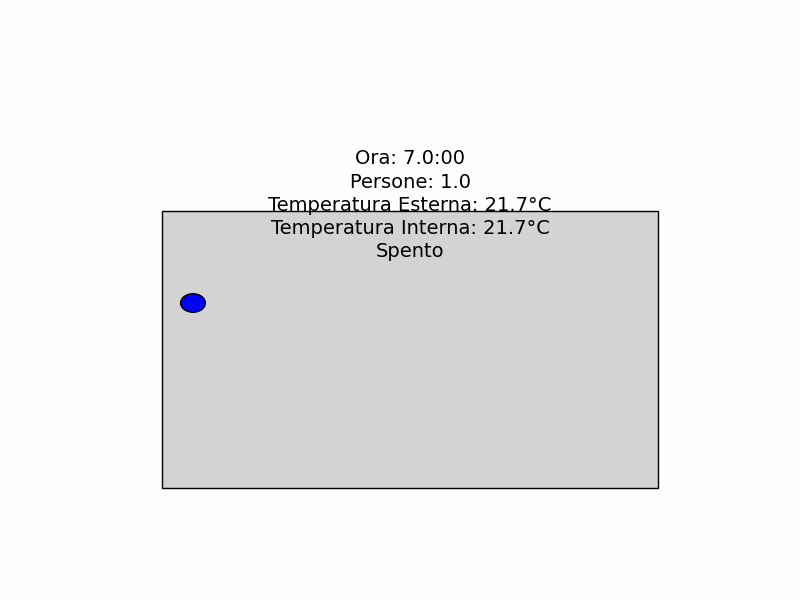

In [29]:
# Mostra la GIF
from IPython.display import Image as IPImage
IPImage(filename='classroom_simulation.gif')